In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install sentinelhub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=f7b78ddbec35735b2759ae2211331dd8b2305ca10a4a1f9f9916a1fd0487e3b8
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 39.3 MB/s eta 0:00:00


In [4]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = '8a46c75d-0e4c-40d2-b00e-e0590ef758ae'
config.sh_client_id = '7ff19b34-1148-42c7-8c77-ba50981048bc'
config.sh_client_secret =  'O4JUyx6UjNhOuWPkYhrF1YNndo4WoSWs'


In [5]:

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

import rasterio
import matplotlib.pyplot as plt


### Functions

In [6]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

### Le boiron specifications

In [7]:
# Exemple de BBOX sur le Boiron:
coords_wgs84 = [6.376052411433987, 46.47981613330913, 6.491362831062974, 46.5810982983339]
resolution = 30

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 30 m resolution: (307, 366) pixels


### Obtain Le Boiron LST image

In [8]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: { bands: 3 }
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [22]:
request_lst = SentinelHubRequest(
    data_folder='gdrive/My Drive/TFG/satellite_data/',
    evalscript=evalscript_lst,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=('2004-07-01', '2004-07-31'),
            mosaicking_order='leastCC',
            #maxcc=0.1
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

In [23]:
lst_imgs = request_lst.get_data(save_data=True)

Image type: uint8, 255


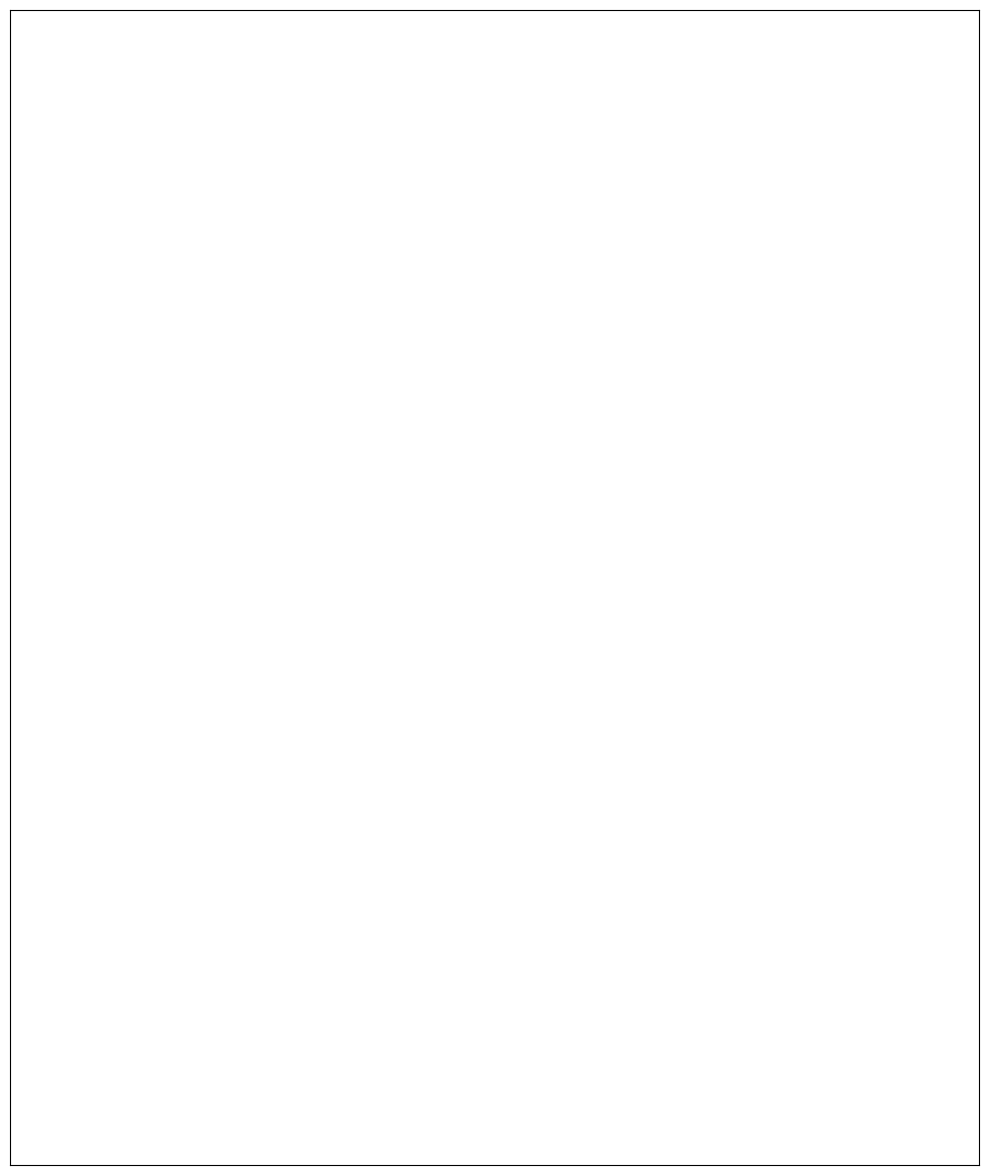

In [24]:
lst_image = lst_imgs[0]
print(f'Image type: {lst_image.dtype}, {lst_image.max()}')

# plot function
# factor 1/255 to scale between 0-1
# factor 6 to increase brightness
plot_image(lst_image, factor=6/255, clip_range=(0,1))

### Raw image

In [ ]:
evalscript_raw_data = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"],
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_raw_data = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_raw_data,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

In [ ]:
brute_imgs = request_raw_data.get_data(save_data=True)
brute_image = brute_imgs[0]

In [ ]:
clip_range1=(0,1)
clip_range2=(0,1)

factor1=6/255
factor2=6/255

image1=brute_image
image2=lst_image

def plot_images_side_by_side(image1, image2, factor1=1.0, factor2=1.0, clip_range1=None, clip_range2=None, **kwargs1):
    """
    Función para plotear dos imágenes lado a lado.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Crear dos subplots

    # Plotear la primera imagen
    if clip_range1 is not None:
        axes[0].imshow(np.clip(image1 * factor1, *clip_range1), **kwargs1)
    else:
        axes[0].imshow(image1 * factor1, **kwargs1)
    axes[0].set_title('Raw image')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plotear la segunda imagen
    if clip_range2 is not None:
        axes[1].imshow(np.clip(image2 * factor2, *clip_range2), **kwargs1)
    else:
        axes[1].imshow(image2 * factor2, **kwargs1)
    axes[1].set_title('Land Surface Temperature')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    plt.tight_layout()
    plt.show()

# Llamada a la función con tus imágenes
plot_images_side_by_side(brute_image, lst_image, factor1, factor2, clip_range1, clip_range2)


Output hidden; open in https://colab.research.google.com to view.

### Load raster images

In [ ]:
def load_raster(filepath,rgb = True):
  with rasterio.open(filepath) as src:
    if rgb:
      red = src.read(1)
      green = src.read(2)
      blue = src.read(3)
      rgb = np.dstack((red, green, blue))
      return rgb, src
    else:
      return src.read(1), src


In [ ]:
meta.transform

Affine(0.0003756039727328557, 0.0, 6.376052411433987,
       0.0, -0.0002767272268436343, 46.5810982983339)

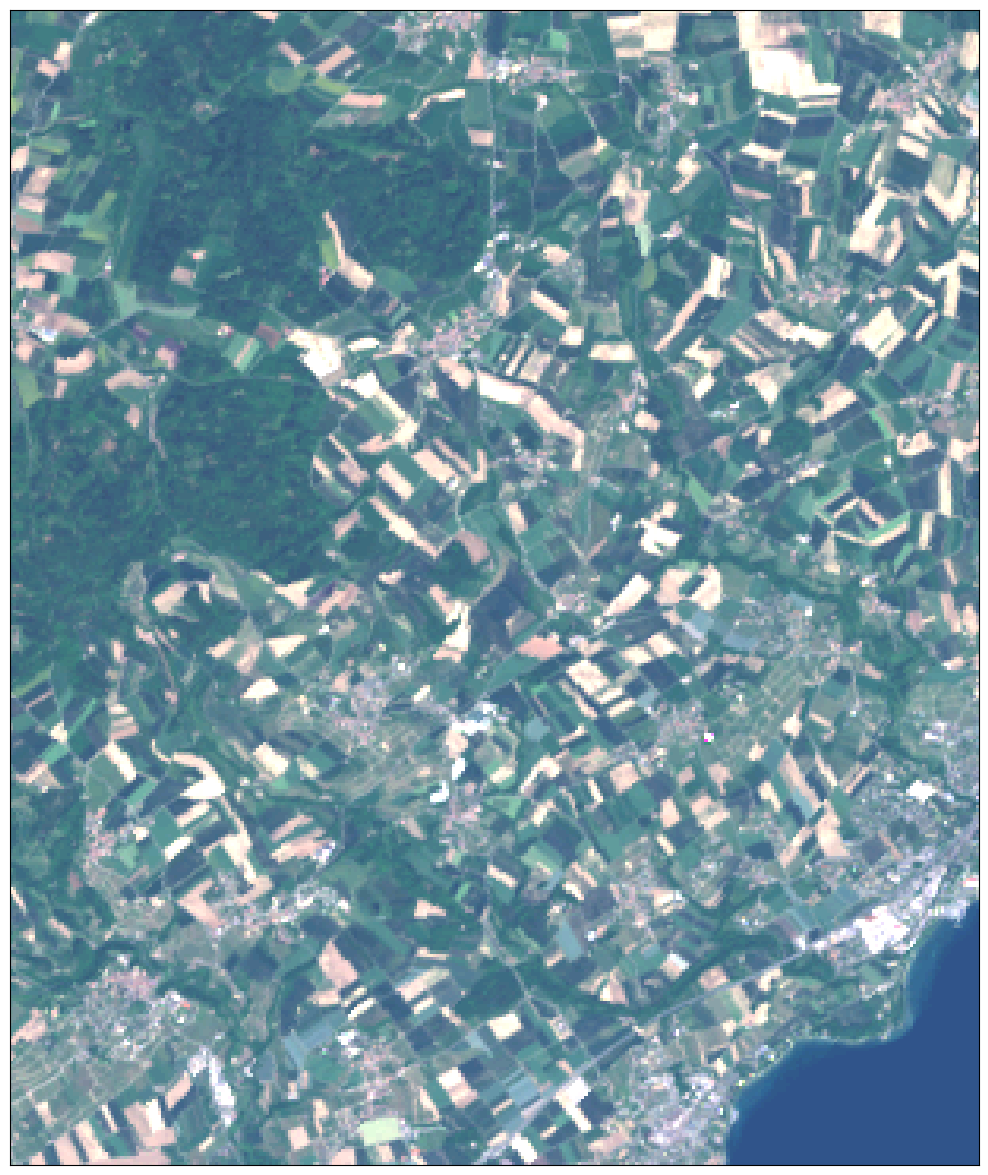

In [ ]:
imagen_path = "/content/gdrive/MyDrive/test_dir/bc840126d5358207400398e4086d4413/response.tiff"
raw_image,meta = load_raster(imagen_path)
plot_image(raw_image, factor=6/255, clip_range=(0,1))

### Project river in raw image

In [ ]:
import geopandas as gpd
river_mask=gpd.read_file('swissTLMBoiron.shp')

In [ ]:
boiron_gdf = river_mask.to_crs(imagen.crs)

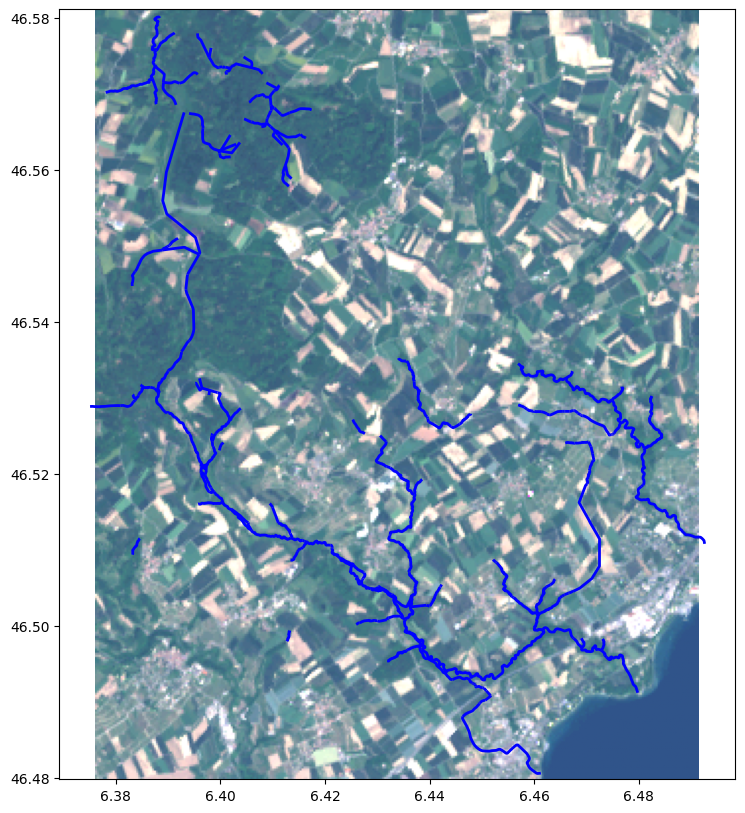

In [ ]:
# Visualizar la imagen y el shapefile
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.clip(raw_image * factor1, *clip_range1), extent=(meta.bounds.left, meta.bounds.right, meta.bounds.bottom, meta.bounds.top))

# Añadir el río sobre la imagen
boiron_gdf.plot(ax=ax, edgecolor='blue', linewidth=2)

# Mostrar el resultado
plt.show()


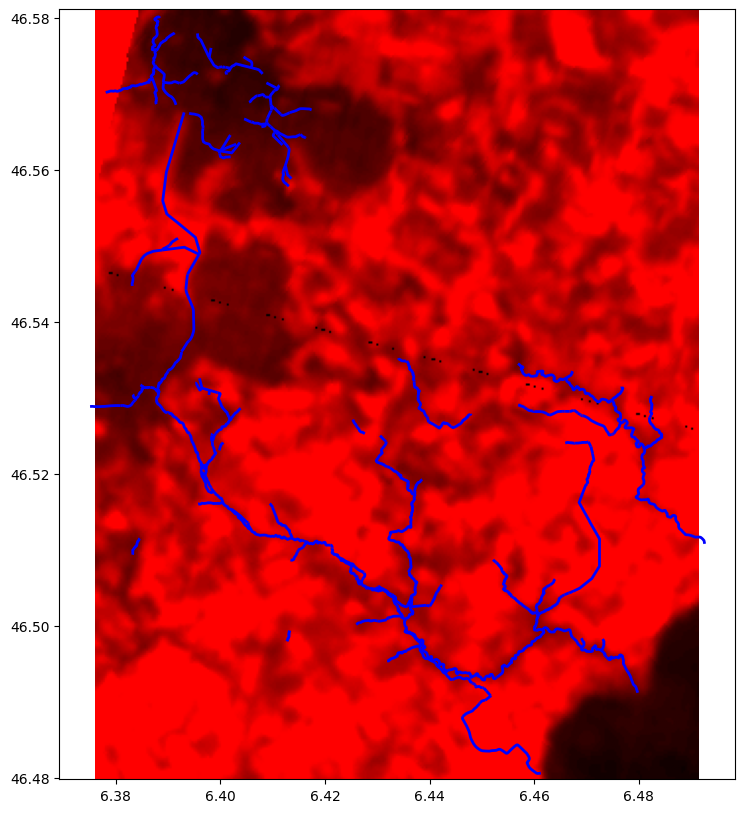

In [ ]:
# Visualizar la imagen y el shapefile
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.clip(image2 * factor1, *clip_range1), extent=(meta.bounds.left, meta.bounds.right, meta.bounds.bottom, meta.bounds.top))

# Añadir el río sobre la imagen
boiron_gdf.plot(ax=ax, edgecolor='blue', linewidth=2)

# Mostrar el resultado
plt.show()

## Correlation

In [ ]:
# Cargar la máscara binaria del río
river_mask_array, mask_meta= load_raster('raster_mask_bw.tif', rgb = False)
river_mask_temp, mask_temp_meta = load_raster('raster_mask_temp.tif', rgb = True )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
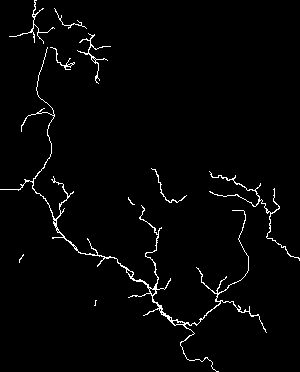

In [ ]:
river_mask_array

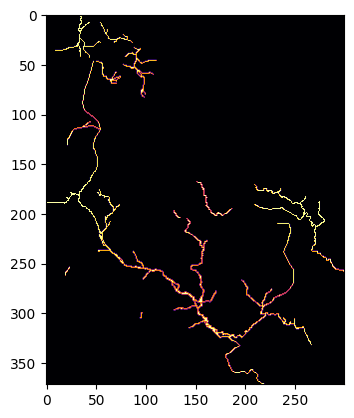

In [ ]:
plt.imshow(np.clip(river_mask_temp*(6/255),0,1),cmap='inferno')

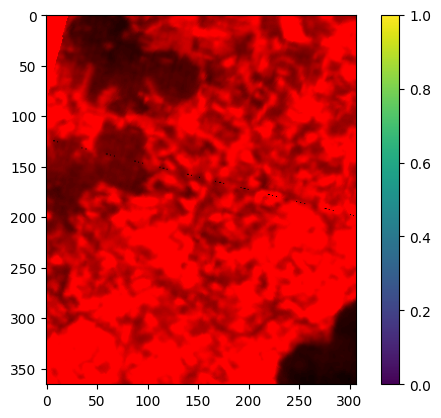

In [ ]:
plt.imshow(np.clip(lst_image*(6/255),0,1))
plt.colorbar()
plt.show()

In [ ]:
rojo = lst_image[:,:,0]
verde = lst_image[:,:,1]
azul = lst_image[:,:,2]

# Convertir la imagen RGB a escala de grises (promedio simple)
temperatura_imagen = 0.2989 * rojo + 0.5870 * verde + 0.1140 * azul

In [ ]:
temperatura_rio = river_mask_temp

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Asegúrate de que las dimensiones de la máscara y la imagen sean las mismas
min_height = min(temperatura_rio.shape[0], temperatura_imagen.shape[0])
min_width = min(temperatura_rio.shape[1], temperatura_imagen.shape[1])

# Recortar ambas imágenes
recortado_rio = temperatura_rio[:min_height, :min_width]
recortado_imagen = temperatura_imagen[:min_height, :min_width]

# Aplicar la máscara del río para extraer los valores donde hay río
masked_temperatura_imagen = np.where(recortado_rio > 0, recortado_imagen, np.nan)


In [ ]:
from scipy.stats import pearsonr
import numpy as np

# Aplanar ambos arrays para comparar
temperatura_imagen_flat = masked_temperatura_imagen.flatten()
temperatura_rio_flat = recortado_rio.flatten()

# Eliminar NaN
mask = ~np.isnan(temperatura_imagen_flat) & ~np.isnan(temperatura_rio_flat)
temperatura_imagen_filtrada = temperatura_imagen_flat[mask]
temperatura_rio_filtrada = temperatura_rio_flat[mask]

# Calcular la correlación de Pearson
correlacion, p_valor = pearsonr(temperatura_imagen_filtrada, temperatura_rio_filtrada)

print(f"Correlación de Pearson: {correlacion}")
print(f"p-valor: {p_valor}")

Correlación de Pearson: nan
p-valor: nan


<ipython-input-120-4ca810b7b2a3>:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlacion, p_valor = pearsonr(temperatura_imagen_filtrada, temperatura_rio_filtrada)
